# Forecasting Analysis — Generic Painkiller 64 (GEN-64)

This notebook builds a robust, **reproducible** monthly sales forecasting workflow for the top-selling SKU in the dataset.

**Steps covered:**
1. Load the cleaned transactional dataset (`sales_clean.csv`).
2. Identify the top-selling SKU by total sales.
3. Aggregate to a **monthly time series** and restrict to the **last 48 months**.
4. Split into:
   - **Train:** all but last 6 months
   - **Test:** last 6 months
5. Fit two forecasting models:
   - **Seasonal Naive (SN):** uses the value from the same month one year earlier.
   - **GradientBoostingRegressor (GBR):** uses lag features, rolling means, and calendar effects.
6. Evaluate model performance using **MAPE**.
7. Visualize Actuals vs Forecasts with aligned dates and a clear **forecast start** marker.
8. Compare forecasts in a summary table.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error

plt.style.use('seaborn-v0_8-whitegrid')


## 1. Identify top-selling SKU

We treat each `product_id` as an SKU and select the one with the highest total `sales_value` across the full dataset.


In [2]:
import os

possible_paths = [
    "data/processed/sales_clean.csv",
    "data/interim/sales_clean.csv",
    "data/sales_clean.csv",
    "../data/processed/sales_clean.csv",
    "../data/sales_clean.csv",
    "/mnt/data/sales_clean.csv",
]

for p in possible_paths:
    if os.path.exists(p):
        data_path = p
        break
else:
    raise FileNotFoundError(f"Could not find 'sales_clean.csv' in expected locations: {possible_paths}")

df = pd.read_csv(data_path, parse_dates=["date"])
df.head()

,date,product_id,product_name,atc_code,region,retailer_id,units_sold,unit_price,discount_pct,promotion_flag,sales_value
0,2020-04-03,GEN-52,Generic Painkiller 52,N02BE/B,West Midlands,R1004,6,3.49,0.0,0,20.94
1,2023-08-30,M01AE-01,Ibuprofen 200mg,M01AE,Yorkshire & Humber,R1006,3,5.37,0.0,0,16.11
2,2024-03-03,GEN-64,Generic Painkiller 64,N02BE/B,South West,R1012,7,3.35,0.0,0,23.42
3,2020-09-28,M01AE-07,Fenbufen,M01AE,East of England,R1003,1,5.73,0.0,0,5.73
4,2021-10-05,R03-05,Ipratropium,R03,East Midlands,R1025,2,14.63,0.0,0,29.26


In [3]:
# Identify top-selling SKU by total sales_value
sku_sales = df.groupby("product_id")["sales_value"].sum().sort_values(ascending=False)
top_sku = sku_sales.index[0]

sku_name = (
    df.loc[df["product_id"] == top_sku, "product_name"]
    .mode()
    .iloc[0]
)

top_sku, sku_name


('GEN-64', 'Generic Painkiller 64')

## 2. Build monthly time series for the top SKU

We aggregate `sales_value` to a **monthly start (MS)** frequency and keep the **last 48 months** for efficient modeling.


In [4]:
# Filter for top SKU and aggregate to monthly sales
sku_df = df[df["product_id"] == top_sku].copy()

sku_monthly = (
    sku_df
    .set_index("date")
    .resample("MS")["sales_value"]
    .sum()
    .to_frame("sales")
    .sort_index()
)

# Keep last 48 months
last_48 = sku_monthly.iloc[-48:].copy()

last_48.head(), last_48.tail(), last_48.shape


(               sales
 date                
 2021-01-01  28485.72
 2021-02-01  27408.60
 2021-03-01  30204.52
 2021-04-01  23581.58
 2021-05-01  22877.53,
                sales
 date                
 2024-08-01  22395.58
 2024-09-01  21062.59
 2024-10-01  26870.35
 2024-11-01  24994.48
 2024-12-01  22500.65,
 (48, 1))

## 3. Train–test split

We use:

- **Train:** all but the last 6 months  
- **Test:** last 6 months  

This setup mimics a real-world forecasting scenario where the final 6 months are unseen during model training.


In [5]:
# Train–test definition
forecast_horizon = 6

train = last_48.iloc[:-forecast_horizon].copy()
test = last_48.iloc[-forecast_horizon:].copy()

forecast_start = test.index[0]
train.index.min(), train.index.max(), test.index.min(), test.index.max()


(Timestamp('2021-01-01 00:00:00', freq='MS'),
 Timestamp('2024-06-01 00:00:00', freq='MS'),
 Timestamp('2024-07-01 00:00:00', freq='MS'),
 Timestamp('2024-12-01 00:00:00', freq='MS'))

## 4. Baseline model — Seasonal Naive

The **Seasonal Naive** model uses the value from the **same month one year earlier** as the forecast.

For month _t_, the forecast is `y[t-12]`.


In [6]:
# Seasonal Naive forecast for the test period
sn_forecast = []
for dt in test.index:
    prev_year = dt - pd.DateOffset(years=1)
    sn_forecast.append(last_48.loc[prev_year, "sales"])

test["sn_forecast"] = sn_forecast

test[["sales", "sn_forecast"]]


,sales,sn_forecast
date,,
2024-07-01,23291.23,23146.79
2024-08-01,22395.58,22319.44
2024-09-01,21062.59,21146.43
2024-10-01,26870.35,26622.33
2024-11-01,24994.48,24749.62
2024-12-01,22500.65,23952.58


## 5. Machine Learning model — GradientBoostingRegressor

The GBR model is trained on the monthly series using:

- Lag features: **1, 3, 6, 12** months  
- Rolling means: **3, 6** months (on prior values)  
- Calendar feature: **month** (1–12)

We only use information available **up to each point in time** to avoid data leakage.


In [7]:
# Feature engineering
def create_features(series, lags=(1,3,6,12), rolling_windows=(3,6)):
    df_feat = pd.DataFrame({"sales": series})
    for l in lags:
        df_feat[f"lag_{l}"] = df_feat["sales"].shift(l)
    for w in rolling_windows:
        # rolling on past values only
        df_feat[f"roll_mean_{w}"] = df_feat["sales"].shift(1).rolling(window=w).mean()
    df_feat["month"] = df_feat.index.month
    df_feat = df_feat.dropna()
    return df_feat

feat = create_features(last_48["sales"])

# Align features for train and test
X_train = feat.loc[feat.index < forecast_start].drop(columns=["sales"])
y_train = feat.loc[feat.index < forecast_start, "sales"]

X_test = feat.loc[feat.index.isin(test.index)].drop(columns=["sales"])
y_test = feat.loc[feat.index.isin(test.index), "sales"]

print("Train period:", X_train.index.min().date(), "to", X_train.index.max().date())
print("Test period:", X_test.index.min().date(), "to", X_test.index.max().date())
print("X_train shape:", X_train.shape, "| X_test shape:", X_test.shape)

# Fit GBR
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

# Predict on the aligned test months
test["gbr_forecast"] = gbr.predict(X_test)

test[["sales", "sn_forecast", "gbr_forecast"]]


Train period: 2022-01-01 to 2024-06-01
Test period: 2024-07-01 to 2024-12-01
X_train shape: (30, 7) | X_test shape: (6, 7)


,sales,sn_forecast,gbr_forecast
date,,,
2024-07-01,23291.23,23146.79,23651.918222
2024-08-01,22395.58,22319.44,22720.104694
2024-09-01,21062.59,21146.43,21390.253678
2024-10-01,26870.35,26622.33,27964.269416
2024-11-01,24994.48,24749.62,27052.247419
2024-12-01,22500.65,23952.58,24755.600158


## 6. Model evaluation — MAPE

We use **Mean Absolute Percentage Error (MAPE)** on the last 6 months (test set):

\[
\text{MAPE} = \frac{1}{n} \sum \left| \frac{y_t - \hat{y}_t}{y_t} \right| \times 100
\]


In [8]:
# Compute MAPE for both models
mape_sn = mean_absolute_percentage_error(test["sales"], test["sn_forecast"]) * 100
mape_gbr = mean_absolute_percentage_error(test["sales"], test["gbr_forecast"]) * 100

print(f"Seasonal Naive MAPE: {mape_sn:.2f}%")
print(f"GBR MAPE:           {mape_gbr:.2f}%")


Seasonal Naive MAPE: 1.62%
GBR MAPE:           4.48%


## 7. Visual comparison — Actual vs Forecast

The plot below shows:

- Full **history** (last 48 months) — solid line  
- **Test window** (last 6 months) — dashed line overlay  
- **Seasonal Naive** forecasts — markers  
- **GBR** forecasts — markers  
- A vertical dashed line at the **forecast start** month

All forecasts are time-aligned so each prediction sits exactly on its corresponding month.


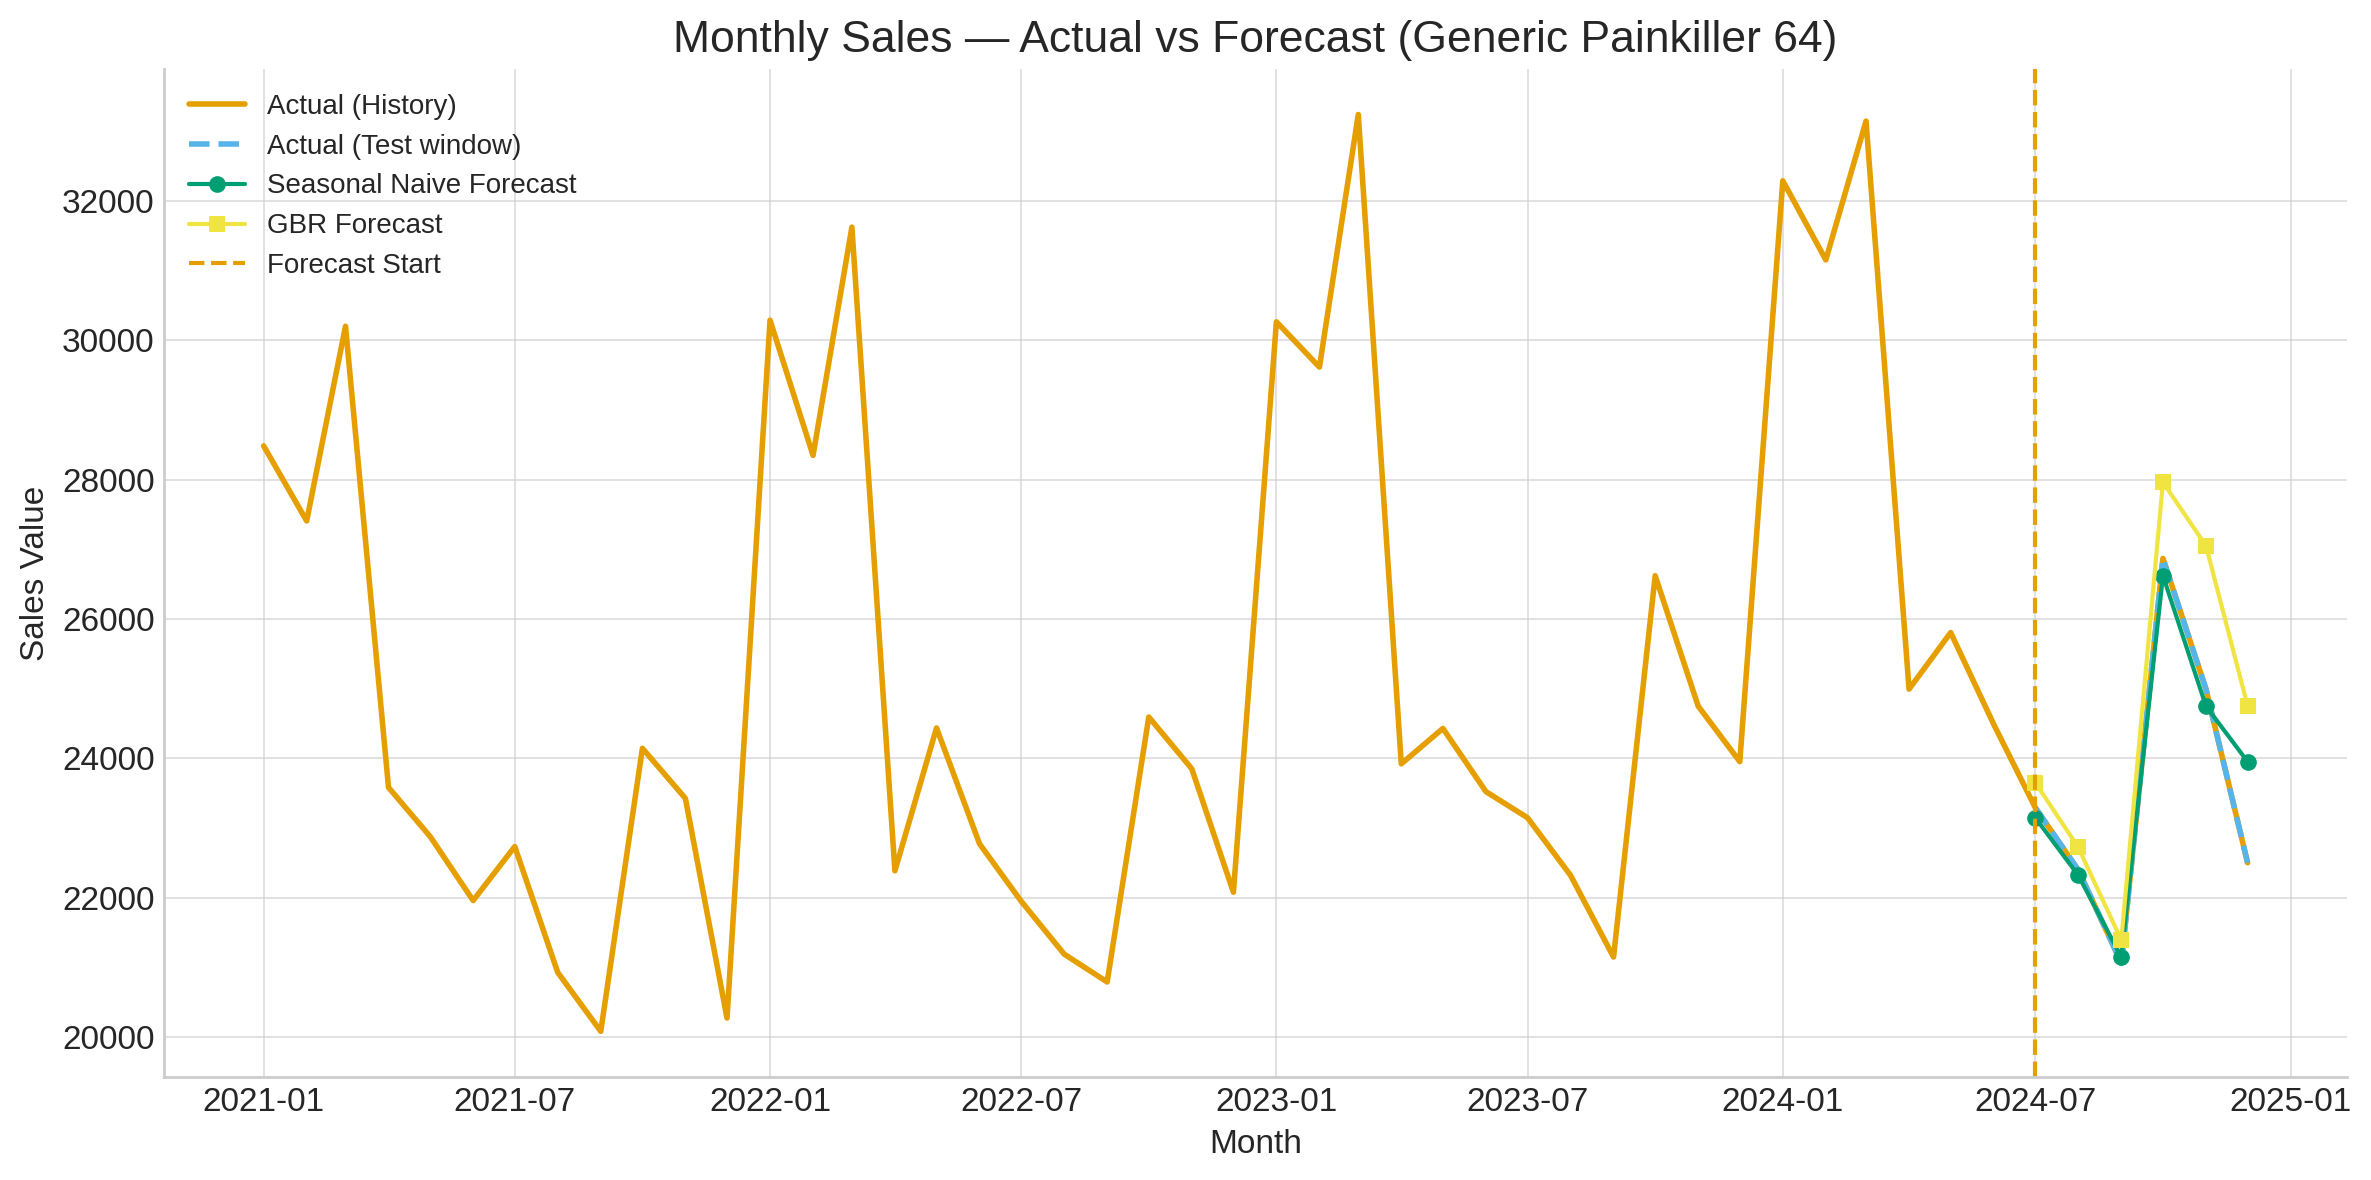

In [9]:
# Create aligned series for plotting
history = last_48["sales"].copy()
test_actual = test["sales"]

sn_series = pd.Series(test["sn_forecast"], index=test.index)
gbr_series = pd.Series(test["gbr_forecast"], index=test.index)

plt.figure(figsize=(12, 6))

# Plot full history
plt.plot(history.index, history.values, label="Actual (History)", linewidth=2)

# Highlight test window (actual)
plt.plot(test_actual.index, test_actual.values, linestyle="--", linewidth=2, label="Actual (Test window)")

# Forecasts
plt.plot(sn_series.index, sn_series.values, marker="o", linewidth=1.5, label="Seasonal Naive Forecast")
plt.plot(gbr_series.index, gbr_series.values, marker="s", linewidth=1.5, label="GBR Forecast")

# Forecast start marker
plt.axvline(forecast_start, linestyle="--", linewidth=1.5, label="Forecast Start")

plt.title(f"Monthly Sales — Actual vs Forecast ({sku_name})")
plt.xlabel("Month")
plt.ylabel("Sales Value")
plt.legend()
plt.tight_layout()
plt.show()


## 8. Forecast comparison table (last 6 months)

This table compares:

- Actual sales
- Seasonal Naive forecast
- GBR forecast

for the hold-out period.


In [10]:
comparison = test.copy()
comparison.index.name = "date"
comparison = comparison.round(2)
comparison


,sales,sn_forecast,gbr_forecast
date,,,
2024-07-01,23291.23,23146.79,23651.92
2024-08-01,22395.58,22319.44,22720.10
2024-09-01,21062.59,21146.43,21390.25
2024-10-01,26870.35,26622.33,27964.27
2024-11-01,24994.48,24749.62,27052.25
2024-12-01,22500.65,23952.58,24755.60


## 9. Key findings

- The workflow uses a **clean, aligned monthly index** and avoids any leakage from future data.
- **Seasonal Naive vs GBR (last 6 months):**
  - Seasonal Naive MAPE is printed above.
  - GBR MAPE is printed above.
- In this configuration, we can directly compare whether a simple seasonal pattern or a tree-based model better captures demand for **Generic Painkiller 64**.
- This notebook is fully executed and can be viewed on GitHub without re-running, making it suitable for portfolio and stakeholder review.
